<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/vae-segmentation/notebooks/Segmentation_DFC2020_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation downstream task: SEN12FLOOD

Model: ResNetUnet \\
Data: SEN12FLOOD \\
Pretrained weights: dependent on pretext tasks



### Environment setup

In [1]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@vae-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision vae-segmentation) to /tmp/pip-install-f909dbjs/ssl-remote-sensing_8f916d0e42124bf7950f339662b27832
  Running command git clone -q https://github.com/AlexanderLontke/ssl-remote-sensing.git /tmp/pip-install-f909dbjs/ssl-remote-sensing_8f916d0e42124bf7950f339662b27832
  Running command git checkout -b vae-segmentation --track origin/vae-segmentation
  Switched to a new branch 'vae-segmentation'
  Branch 'vae-segmentation' set up to track remote branch 'vae-segmentation' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 798 kB 28.4 MB/s 
     |████████████████████████████████| 20.9 MB 67.7 MB/s 
     |████████████████████████████████| 1.9 MB 

In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from ssl_remote_sensing.data.dfc2020 import DFC2020
from ssl_remote_sensing.downstream_tasks.segmentation.utils import patch_first_conv, get_metrics
from ssl_remote_sensing.downstream_tasks.segmentation.model import ResNetUNet
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility
from ssl_remote_sensing.constants import RANDOM_INITIALIZATION
from ssl_remote_sensing.pretext_tasks.utils import (
    load_encoder_checkpoint_from_pretext_model,
)

/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapContr

In [4]:
import rasterio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score
import gdown
import tarfile

/usr/local/lib/python3.8/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [5]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
RANDOM_INITIALIZATION

'random'

In [9]:
g_drive_path = "/content/drive/MyDrive/deep_learning_checkpoints"
check_point_paths = os.listdir(g_drive_path)
check_point_paths += [RANDOM_INITIALIZATION]
check_point_paths = [g_drive_path + "/" + x for x in check_point_paths]
check_point_paths

['/content/drive/MyDrive/deep_learning_checkpoints/SimCLR_ResNet18_adam_bs2250-v1.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/vae.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/BiGAN_encoder_ckpt_100.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/random']

### Hyperparameter setup

In [44]:
# Model Setup
class Hparams:
    def __init__(self):
        self.epochs = 2 # number of training epochs for pretext tasks
        self.seed = 1234  # randomness seed
        self.gradient_accumulation_steps = 1  # gradient accumulation steps
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.optim = "Adam"
        self.cuda = True  # use coda
        self.transform = False
        self.split = False

In [45]:
train_config = Hparams()

In [46]:
reproducibility(train_config)

## Data

In [13]:
dfc2020_path = '/content/drive/MyDrive/dfc2020/dfc_2020.tar.gz'

In [14]:
with tarfile.open(dfc2020_path, mode="r") as tar:
    tar.extractall(path='/content/')

In [15]:
# import os
# import rasterio
# import numpy as np
# import glob
# import torch.utils.data as data
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# class DFC2020(data.Dataset):
#     """PyTorch dataset class for the DFC2020 dataset"""

#     def __init__(self,
#                  path,
#                  subset="val",
#                  no_savanna=False,
#                  use_s2hr=False,
#                  use_s2mr=False,
#                  use_s2lr=False,
#                  use_s1=False):
#         """Initialize the dataset"""

#         # inizialize
#         super(DFC2020, self).__init__()

#         # make sure parameters are okay
#         if not (use_s2hr or use_s2mr or use_s2lr or use_s1):
#             raise ValueError("No input specified, set at least one of "
#                              + "use_[s2hr, s2mr, s2lr, s1] to True!")
#         self.use_s2hr = use_s2hr
#         self.use_s2mr = use_s2mr
#         self.use_s2lr = use_s2lr
#         self.use_s1 = use_s1
#         assert subset in ["val", "test"]
#         self.no_savanna = no_savanna

#         # provide number of input channels
#         self.n_inputs = get_ninputs(use_s1, use_s2hr, use_s2mr, use_s2lr)

#         # provide index of channel(s) suitable for previewing the input
#         self.display_channels, self.brightness_factor = get_display_channels(
#                                                             use_s2hr,
#                                                             use_s2mr,
#                                                             use_s2lr)

#         # provide number of classes
#         if no_savanna:
#             self.n_classes = max(DFC2020_CLASSES) - 1
#         else:
#             self.n_classes = max(DFC2020_CLASSES)

#         # make sure parent dir exists
#         assert os.path.exists(path)

#         # build list of sample paths
#         if subset == "val":
#             path = os.path.join(path, "ROIs0000_validation", "s2_validation")
#         else:
#             path = os.path.join(path, "ROIs0000_test", "s2_0")
#         s2_locations = glob.glob(os.path.join(path, "*.tif"), recursive=True)
#         self.samples = []
#         for s2_loc in tqdm(s2_locations, desc="[Load]"):
#             s1_loc = s2_loc.replace("_s2_", "_s1_").replace("s2_", "s1_")
#             lc_loc = s2_loc.replace("_dfc_", "_lc_").replace("s2_", "dfc_")
#             self.samples.append({"lc": lc_loc, "s1": s1_loc, "s2": s2_loc,
#                                  "id": os.path.basename(s2_loc)})

#         # sort list of samples
#         self.samples = sorted(self.samples, key=lambda i: i['id'])

#         print("loaded", len(self.samples),
#               "samples from the dfc2020 subset", subset)

#     def __getitem__(self, index):
#         """Get a single example from the dataset"""

#         # get and load sample from index file
#         sample = self.samples[index]
#         return load_sample(sample, self.use_s1, self.use_s2hr, self.use_s2mr,
#                            self.use_s2lr, no_savanna=self.no_savanna,
#                            igbp=False)

#     def __len__(self):
#         """Get number of samples in the dataset"""
#         return len(self.samples)

#     def visualize_observation(self,idx):
#         sample = self.__getitem__(idx)
#         img = sample["image"]
#         label = sample["label"]

#         print("id:", sample["id"], "\n",
#           "input shape:", img.shape, "\n",
#           "label shape:", label.shape, "\n")

#         fig, axs = plt.subplots(1, 2, figsize=(10, 6))

#         img_rgb = img[[3, 2, 1], :, :]
#         img_rgb = np.transpose(img_rgb, (1, 2, 0))
#         img_rgb = img_rgb / img_rgb.max()

#         axs[0].imshow(img_rgb)
#         axs[0].set_title("Sentinel-2 RGB")
#         axs[0].axis("off")

#         mask = label.squeeze()

#         axs[1].imshow(mask)
#         axs[1].set_title("Groundtruth Mask")
#         axs[1].axis("off")

#         plt.show()

# #mapping from igbp to dfc2020 classes
# DFC2020_CLASSES = [
#     0,  # class 0 unused in both schemes
#     1,
#     1,
#     1,
#     1,
#     1,
#     2,
#     2,
#     3,  # --> will be masked if no_savanna == True
#     3,  # --> will be masked if no_savanna == True
#     4,
#     5,
#     6,  # 12 --> 6
#     7,  # 13 --> 7
#     6,  # 14 --> 6
#     8,
#     9,
#     10
#     ]

# DFC2020_CLASSES_MAP = {
#     1: "Forest",
#     2: "Shrubland",
#     # 3: "Savanna",
#     3: "Grassland",
#     4: "Wetlands",
#     5: "Croplands",
#     6: "Urban/Built-up",
#     7: "Snow/Ice",
#     8: "Barren",
#     9: "Water",
# }

# # indices of sentinel-2 high-/medium-/low-resolution bands
# S2_BANDS_HR = [2, 3, 4, 8]
# S2_BANDS_MR = [5, 6, 7, 9, 12, 13]
# S2_BANDS_LR = [1, 10, 11]

# # util function for reading s2 data
# def load_s2(path, use_hr, use_mr, use_lr):
#     bands_selected = []
#     if use_hr:
#         bands_selected = bands_selected + S2_BANDS_HR
#     if use_mr:
#         bands_selected = bands_selected + S2_BANDS_MR
#     if use_lr:
#         bands_selected = bands_selected + S2_BANDS_LR
#     bands_selected = sorted(bands_selected)
#     with rasterio.open(path) as data:
#         s2 = data.read(bands_selected)
#     s2 = s2.astype(np.float32)
#     s2 = np.clip(s2, 0, 10000)
#     s2 /= 10000
#     s2 = s2.astype(np.float32)
#     return s2

# # util function for reading s1 data
# def load_s1(path):
#     with rasterio.open(path) as data:
#         s1 = data.read()
#     s1 = s1.astype(np.float32)
#     s1 = np.nan_to_num(s1)
#     s1 = np.clip(s1, -25, 0)
#     s1 /= 25
#     s1 += 1
#     s1 = s1.astype(np.float32)
#     return s1

# # util function for reading lc data
# def load_lc(path, no_savanna=False, igbp=True):

#     # load labels
#     with rasterio.open(path) as data:
#         lc = data.read(1)

#     # convert IGBP to dfc2020 classes
#     if igbp:
#         lc = np.take(DFC2020_CLASSES, lc)
#     else:
#         lc = lc.astype(np.int64)

#     # adjust class scheme to ignore class savanna
#     if no_savanna:
#         lc[lc == 3] = 0
#         lc[lc > 3] -= 1

#     # convert to zero-based labels and set ignore mask
#     lc -= 1
#     lc[lc == -1] = 255
#     return lc

# # util function for reading data from single sample
# def load_sample(sample, use_s1, use_s2hr, use_s2mr, use_s2lr,
#                 no_savanna=False, igbp=True, unlabeled=False):

#     use_s2 = use_s2hr or use_s2mr or use_s2lr

#     # load s2 data
#     if use_s2:
#         img = load_s2(sample["s2"], use_s2hr, use_s2mr, use_s2lr)

#     # load s1 data
#     if use_s1:
#         if use_s2:
#             img = np.concatenate((img, load_s1(sample["s1"])), axis=0)
#         else:
#             img = load_s1(sample["s1"])

#     # load label
#     if unlabeled:
#         return {'image': img, 'id': sample["id"]}
#     else:
#         lc = load_lc(sample["lc"], no_savanna=no_savanna, igbp=igbp)

#         return {'image': img, 'label': lc, 'id': sample["id"]}

# # util function for reading data from single sample
# def load_sample_visual(sample, use_s1, use_s2hr, use_s2mr, use_s2lr,
#                 no_savanna=False, igbp=True, unlabeled=False):

#     use_s2 = use_s2hr or use_s2mr or use_s2lr

#     # load s2 data
#     if use_s2:
#         img = load_s2(sample["s2"], use_s2hr, use_s2mr, use_s2lr)

#     # load s1 data
#     if use_s1:
#         if use_s2:
#             img = np.concatenate((img, load_s1(sample["s1"])), axis=0)
#         else:
#             img = load_s1(sample["s1"])

#     # load label
#     if unlabeled:
#         return {'image': img, 'id': sample["id"]}
#     else:
#         lc = torch.tensor(load_lc(sample["lc"], no_savanna=no_savanna, igbp=igbp))

#         return {'image': img, 'label': lc, 'id': sample["id"]}

# # calculate number of input channels
# def get_ninputs(use_s1, use_s2hr, use_s2mr, use_s2lr):
#     n_inputs = 0
#     if use_s2hr:
#         n_inputs += len(S2_BANDS_HR)
#     if use_s2mr:
#         n_inputs += len(S2_BANDS_MR)
#     if use_s2lr:
#         n_inputs += len(S2_BANDS_LR)
#     if use_s1:
#         n_inputs += 2
#     return n_inputs

# # select channels for preview images
# def get_display_channels(use_s2hr, use_s2mr, use_s2lr):
#     if use_s2hr and use_s2lr:
#         display_channels = [3, 2, 1]
#         brightness_factor = 3
#     elif use_s2hr:
#         display_channels = [2, 1, 0]
#         brightness_factor = 3
#     elif not (use_s2hr or use_s2mr or use_s2lr):
#         display_channels = 0
#         brightness_factor = 1
#     else:
#         display_channels = 0
#         brightness_factor = 3
#     return (display_channels, brightness_factor)

In [16]:
# # subset - 'val' 986
# # subset - 'test' 5128

# # train_set for sentinel-2|
# trainset = DFC2020('/content/dfc_data', subset="test", use_s1=False, use_s2lr=True, use_s2hr=True,
#                  use_s2mr=True, no_savanna=True)
# valset = DFC2020('/content/dfc_data', subset="val", use_s1=False, use_s2lr=True, use_s2hr=True,
#                  use_s2mr=True, no_savanna=True)

In [15]:
from torch.utils.data import random_split

In [16]:
dataset = DFC2020('/content/dfc_data', subset="test", use_s1=False, use_s2lr=True, use_s2hr=True,
                 use_s2mr=True, no_savanna=True)
trainset, valset = random_split(dataset, [4102, 1026])

[Load]: 100%|██████████| 5128/5128 [00:00<00:00, 31413.79it/s]

loaded 5128 samples from the dfc2020 subset test


id: ROIs0000_test_s2_0_p1150.tif 
 input shape: (13, 256, 256) 
 label shape: (256, 256) 



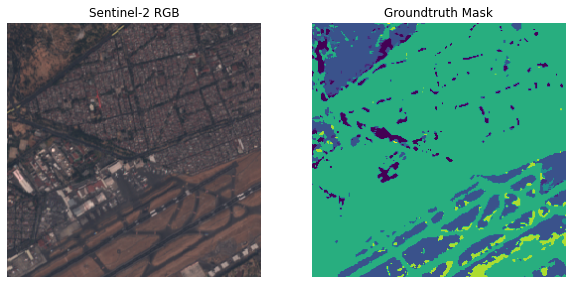

In [17]:
dataset.visualize_observation(170)

In [18]:
train_loader = DataLoader(trainset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)
val_loader = DataLoader(valset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)

In [19]:
next(iter(train_loader))["label"].shape

torch.Size([8, 256, 256])

## Segmentation Model

In [22]:
# from torchvision.models import resnet18
# pretrained_weights = resnet18(pretrained = False)
# patch_first_conv(pretrained_weights ,13,default_in_channels=3)
# model = ResNetUNet(9,encoder = pretrained_weights, gan_encoder=False)
# model = model.to(device)

In [20]:
loss_fn = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')
# optimizer = torch.optim.Adam(model.parameters(), lr=train_config.lr)

In [24]:
# from torchmetrics import Accuracy
# from torchmetrics.functional.classification import multiclass_jaccard_index

In [25]:
# model_dir = '/content/drive/My Drive/deep_learning_segmentation_checkpoints'
# model_path = os.path.join(model_dir,f'segmentation_pretrained_imagenet.ckpt')

In [30]:
# import tqdm
# from torchmetrics import Accuracy
# from torchmetrics.functional.classification import multiclass_jaccard_index

# def train(model):
#     # Initialise the optimizer
#     if train_config.optim == "Adam":
#         optimizer = torch.optim.Adam(model.parameters(), lr=train_config.lr)
#     elif train_config.optim == "SGD":
#         optimizer = torch.optim.SGD(model.parameters(), lr=train_config.lr)

#     model = model.to(device)

#         # Create lists for logging losses and evalualtion metrics:
#     train_losses = []
#     train_accs = []
#     train_ious = []

#     val_losses = []
#     val_accs = []
#     val_ious = []

#     # IoU
#     # jaccard = JaccardIndex(task="multiclass", num_classes=9).to(device)

#     # accuracy
#     accuracy = Accuracy(task="multiclass", num_classes=9).to(device)

#     # For every epoch 
#     for epoch in range(2):
#         epoch_loss = 0
#         progress = tqdm(
#             enumerate(train_loader), desc="Train Loss: ",
#             total=len(train_loader)
#         )
        
#         # Specify you are in training mode
#         model.train()
        
#         epoch_train_loss = 0
#         epoch_val_loss = 0

#         epoch_train_ious = 0
#         epoch_val_ious = 0

#         epoch_train_accs = 0
#         epoch_val_accs = 0

#         for i, batch in progress:
#                 # Transfer data to GPU if available
#                 data = batch["image"].float().to(device)
#                 label = batch['label'].long().to(device)
                
#                 # Make a forward pass
#                 output = model(data)

#                 # Compute IoU
#                 epoch_train_ious += multiclass_jaccard_index(output.to(device), label.int(), num_classes=9)/ len(train_loader)

#                 # Compute pixel accuracies
#                 epoch_train_accs += accuracy(output.to(device), label.int())/ len(train_loader)
                
#                 # Compute the loss
#                 loss = loss_fn(output, label)
                
#                 # Clear the gradients
#                 optimizer.zero_grad()

#                 # Calculate gradients 
#                 loss.backward()

#                 # Update Weights
#                 optimizer.step()
                
#                 # Accumulate the loss over the eopch
#                 epoch_train_loss += loss / len(train_loader)

#                 progress.set_description("Epoch = {}, Train Loss: {:.4f}".format(epoch+1,
#                                             epoch_train_loss))

#         progress = tqdm(
#             enumerate(val_loader), desc="val Loss: ",
#             total=len(val_loader), position=0, leave=True,)
        
#         # Specify you are in evaluation mode
#         model.eval()
        
#         # Deactivate autograd engine (no backpropagation allowed)
#         with torch.no_grad():
#             epoch_val_loss = 0
#             for j, batch in progress:
#                 # Transfer Data to GPU if available
#                 data = batch["image"].float().to(device)
#                 label = batch['label'].long().to(device)

#                 # Make a forward pass
#                 output = model(data)

#                 # Compute IoU
#                 epoch_val_ious += multiclass_jaccard_index(output.to(device), label.int(), num_classes=9)/ len(val_loader)

#                 # Compute pixel accuracies
#                 epoch_val_accs += accuracy(output.to(device), label.int())/ len(val_loader)
                
#                 # Compute the loss
#                 val_loss = loss_fn(output, label)
                            
#                 # Accumulate the loss over the epoch
#                 epoch_val_loss += val_loss / len(val_loader)

#                 progress.set_description("Validation Loss: {:.4f}".format(
#                                         epoch_val_loss))
        
#         if epoch == 0:
#             best_val_loss = epoch_val_loss
#         else:
#             if epoch_val_loss <= best_val_loss:
#                 best_val_loss = epoch_val_loss
#                 # Save only the best model
#                 torch.save(model.state_dict(), model_path)
#                 print('Saving Model...')

#         # save result to wandb
#         wandb.log({'train_loss_segmentation': epoch_train_loss, 'val_loss_segmentation': epoch_val_loss, 
#                   'train_iou_segmentation': epoch_train_ious, 'val_iou_segmentation':epoch_val_ious,
#                     'train_acc_segmentation': epoch_train_accs, 'val_acc_segmentation':epoch_val_accs})

#         # Save losses in list, so that we can visualise them later. 
#         train_losses.append(epoch_train_loss.cpu().detach().numpy())
#         val_losses.append(epoch_val_loss.cpu().detach().numpy())

#         # Save IoUs in list, so that we can visualise them later. 
#         train_ious.append(epoch_train_ious.cpu().detach().numpy())
#         val_ious.append(epoch_val_ious.cpu().detach().numpy())
#         print(f'train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}')

#         # Save accuracies in list, so that we can visualise them later. 
#         train_accs.append(epoch_train_accs.cpu().detach().numpy())
#         val_accs.append(epoch_val_accs.cpu().detach().numpy())
#         print(f'train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}')

#     print('Finished Training')

In [47]:
from tqdm import tqdm
import torch
import wandb
from torchmetrics import Accuracy
from torchmetrics.functional.classification import multiclass_jaccard_index

def train(model,train_config,train_loader,val_loader,loss_fn,device,model_path,wandb = wandb):
    # Initialise the optimizer
    if train_config.optim == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=train_config.lr)
    elif train_config.optim == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=train_config.lr)

    model = model.to(device)

        # Create lists for logging losses and evalualtion metrics:
    train_losses = []
    train_accs = []
    train_ious = []

    val_losses = []
    val_accs = []
    val_ious = []

    # IoU
    # jaccard = JaccardIndex(task="multiclass", num_classes=9).to(device)

    # accuracy
    accuracy = Accuracy(task="multiclass", num_classes=9).to(device)

    # For every epoch 
    for epoch in range(train_config.epochs):
        epoch_loss = 0
        progress = tqdm(
            enumerate(train_loader), desc="Train Loss: ",
            total=len(train_loader)
        )
        
        # Specify you are in training mode
        model.train()
        
        epoch_train_loss = 0
        epoch_val_loss = 0

        epoch_train_ious = 0
        epoch_val_ious = 0

        epoch_train_accs = 0
        epoch_val_accs = 0

        for i, batch in progress:
                # Transfer data to GPU if available
                data = batch["image"].float().to(device)
                label = batch['label'].long().to(device)
                
                # Make a forward pass
                output = model(data)

                # Compute IoU
                epoch_train_ious += multiclass_jaccard_index(output.to(device), label.int(), num_classes=9)/ len(train_loader)

                # Compute pixel accuracies
                epoch_train_accs += accuracy(output.to(device), label.int())/ len(train_loader)
                
                # Compute the loss
                loss = loss_fn(output, label)
                
                # Clear the gradients
                optimizer.zero_grad()

                # Calculate gradients 
                loss.backward()

                # Update Weights
                optimizer.step()
                
                # Accumulate the loss over the eopch
                epoch_train_loss += loss / len(train_loader)

                progress.set_description("Epoch = {}, Train Loss: {:.4f}".format(epoch+1,
                                            epoch_train_loss))

        progress = tqdm(
            enumerate(val_loader), desc="val Loss: ",
            total=len(val_loader), position=0, leave=True,)
        
        # Specify you are in evaluation mode
        model.eval()
        
        # Deactivate autograd engine (no backpropagation allowed)
        with torch.no_grad():
            epoch_val_loss = 0
            for j, batch in progress:
                # Transfer Data to GPU if available
                data = batch["image"].float().to(device)
                label = batch['label'].long().to(device)

                # Make a forward pass
                output = model(data)

                # Compute IoU
                epoch_val_ious += multiclass_jaccard_index(output.to(device), label.int(), num_classes=9)/ len(val_loader)

                # Compute pixel accuracies
                epoch_val_accs += accuracy(output.to(device), label.int())/ len(val_loader)
                
                # Compute the loss
                val_loss = loss_fn(output, label)
                            
                # Accumulate the loss over the epoch
                epoch_val_loss += val_loss / len(val_loader)

                progress.set_description("Validation Loss: {:.4f}".format(
                                        epoch_val_loss))
        
        if epoch == 0:
            best_val_loss = epoch_val_loss
        else:
            if epoch_val_loss <= best_val_loss:
                best_val_loss = epoch_val_loss
                # Save only the best model
                torch.save(model.state_dict(), model_path)
                print('Saving Model...')

        # save result to wandb
        wandb.log({'train_loss_segmentation': epoch_train_loss, 'val_loss_segmentation': epoch_val_loss, 
                  'train_iou_segmentation': epoch_train_ious, 'val_iou_segmentation':epoch_val_ious,
                    'train_acc_segmentation': epoch_train_accs, 'val_acc_segmentation':epoch_val_accs})

        # Save losses in list, so that we can visualise them later. 
        train_losses.append(epoch_train_loss.cpu().detach().numpy())
        val_losses.append(epoch_val_loss.cpu().detach().numpy())

        # Save IoUs in list, so that we can visualise them later. 
        train_ious.append(epoch_train_ious.cpu().detach().numpy())
        val_ious.append(epoch_val_ious.cpu().detach().numpy())
        print(f'train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}')

        # Save accuracies in list, so that we can visualise them later. 
        train_accs.append(epoch_train_accs.cpu().detach().numpy())
        val_accs.append(epoch_val_accs.cpu().detach().numpy())
        print(f'train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}')

    print('Finished Training')

In [39]:
# def visualize_result(idx,bst_model):

#     if not idx:
#         idx = random.randint(0, len(valset))
#         print('Validation image ID: {}'.format(idx))
    
#     sample = valset.__getitem__(idx)
#     img = sample["image"]
#     label = sample["label"]

#     fig, axs = plt.subplots(1, 3, figsize=(10, 6))

#     img_rgb = img[[3, 2, 1], :, :]
#     img_rgb = np.transpose(img_rgb, (1, 2, 0))
#     img_rgb = img_rgb / img_rgb.max()

#     mask = label.squeeze()

#     input_img = torch.from_numpy(img)
#     input_img = torch.unsqueeze(input_img.float().to(device),0)
#     output = bst_model(input_img)
#     output = torch.nn.functional.softmax(output, dim=1)
#     output = torch.argmax(output, dim=1) 
#     output = output.to('cpu').squeeze(0).numpy()

#     axs[0].imshow(img_rgb)
#     axs[0].set_title("Sentinel-2 RGB")
#     axs[0].axis("off")

#     axs[1].imshow(mask)
#     axs[1].set_title("Groundtruth Mask")
#     axs[1].axis("off")

#     axs[2].imshow(output)
#     axs[2].set_title("Predicted Mask")
#     axs[2].axis("off")


#     plt.show()

In [48]:
from PIL import Image

def visualize_result(idx,bst_model,valset,device,wandb = wandb,model_name=None):

    if not idx:
        idx = random.randint(0, len(valset))
        print('Validation image ID: {}'.format(idx))
    
    sample = valset.__getitem__(idx)
    img = sample["image"]
    label = sample["label"]

    fig, axs = plt.subplots(1, 3, figsize=(10, 6))

    img_rgb = img[[3, 2, 1], :, :]
    img_rgb = np.transpose(img_rgb, (1, 2, 0))
    img_rgb = img_rgb / img_rgb.max()
    
    mask = label.squeeze()

    input_img = torch.from_numpy(img)
    input_img = torch.unsqueeze(input_img.float().to(device),0)
    output = bst_model(input_img)
    output = torch.nn.functional.softmax(output, dim=1)
    output = torch.argmax(output, dim=1) 
    output = output.to('cpu').squeeze(0).numpy()

    # wandb log
    img_log = wandb.Image(img_rgb, caption="Sentinel-2 RGB")
    wandb.log({f"Sentinal-2 RGB: {model_name}": img_log})
    mask_log = wandb.Image(Image.fromarray(np.uint8(mask)).convert('RGB'), caption="Groundtruth Mask")
    wandb.log({f"Groundtruth Mask: {model_name}": mask_log})
    output_log = wandb.Image(Image.fromarray(np.uint8(output)).convert('RGB'), caption="Predicted Mask")
    wandb.log({f"Predicted Mask: {model_name}": output_log})

    axs[0].imshow(img_rgb)
    axs[0].set_title("Sentinel-2 RGB")
    axs[0].axis("off")

    axs[1].imshow(mask)
    axs[1].set_title("Groundtruth Mask")
    axs[1].axis("off")

    axs[2].imshow(output)
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.show()

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


Validation Loss: 0.7101: 100%|██████████| 129/129 [00:15<00:00,  8.21it/s]

train_iou is 0.2869, val_iou is 0.3277
train_acc is 0.6789, val_acc is 0.7454



Validation Loss: 0.6035: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]


Saving Model...
train_iou is 0.3546, val_iou is 0.4097
train_acc is 0.7553, val_acc is 0.7914
Finished Training


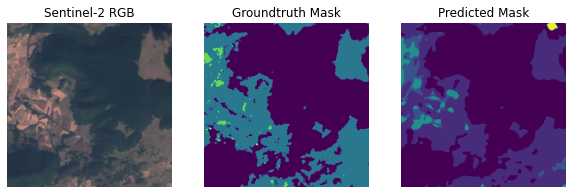

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁█
train_iou_segmentation,▁█
train_loss_segmentation,█▁
val_acc_segmentation,▁█
val_iou_segmentation,▁█
val_loss_segmentation,█▁
train_acc_segmentation,0.75529
train_iou_segmentation,0.35462
train_loss_segmentation,0.68132
val_acc_segmentation,0.7914
val_iou_segmentation,0.40972


Validation Loss: 0.7125: 100%|██████████| 129/129 [00:15<00:00,  8.16it/s]

train_iou is 0.2905, val_iou is 0.3360
train_acc is 0.6848, val_acc is 0.7447



Validation Loss: 0.6310: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]


Saving Model...
train_iou is 0.3563, val_iou is 0.3850
train_acc is 0.7578, val_acc is 0.7743
Finished Training


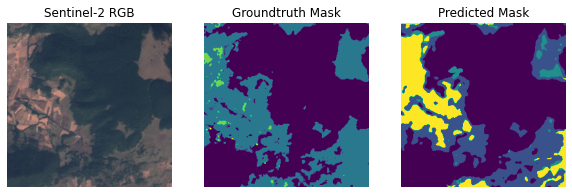

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁█
train_iou_segmentation,▁█
train_loss_segmentation,█▁
val_acc_segmentation,▁█
val_iou_segmentation,▁█
val_loss_segmentation,█▁
train_acc_segmentation,0.75781
train_iou_segmentation,0.35631
train_loss_segmentation,0.67735
val_acc_segmentation,0.77432
val_iou_segmentation,0.38497


Validation Loss: 0.6973: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]

train_iou is 0.2859, val_iou is 0.3561
train_acc is 0.6777, val_acc is 0.7553



Epoch = 2, Train Loss: 0.3851:  57%|█████▋    | 292/513 [01:44<01:18,  2.82it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f5d60e5e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Validation Loss: 0.6755: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]


Saving Model...
train_iou is 0.3579, val_iou is 0.3658
train_acc is 0.7573, val_acc is 0.7616
Finished Training


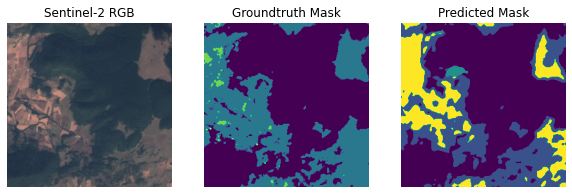

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁█
train_iou_segmentation,▁█
train_loss_segmentation,█▁
val_acc_segmentation,▁█
val_iou_segmentation,▁█
val_loss_segmentation,█▁
train_acc_segmentation,0.75727
train_iou_segmentation,0.35789
train_loss_segmentation,0.67188
val_acc_segmentation,0.76164
val_iou_segmentation,0.36578


Validation Loss: 0.9385: 100%|██████████| 129/129 [00:15<00:00,  8.23it/s]

train_iou is 0.2855, val_iou is 0.2699
train_acc is 0.6800, val_acc is 0.6458



Validation Loss: 0.6296: 100%|██████████| 129/129 [00:15<00:00,  8.24it/s]


Saving Model...
train_iou is 0.3474, val_iou is 0.3656
train_acc is 0.7474, val_acc is 0.7766
Finished Training


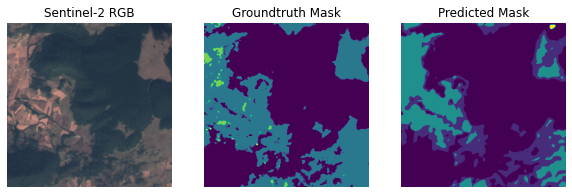

In [49]:
for filename in check_point_paths:
    # Update checkpoint name
    train_config.checkpoint_name = filename
    # Load Encoder from different pre-text architectures
    encoder = load_encoder_checkpoint_from_pretext_model(
        path_to_checkpoint=filename,
    )
    patch_first_conv(encoder,13,default_in_channels=3)

    model_name = filename.split("/")[-1].split(".")[0]
    model_dir = '/content/drive/My Drive/deep_learning_segmentation_checkpoints'
    model_path = os.path.join(model_dir,f'segmentation_{model_name}.ckpt')
    # make sure the directory path exists
    assert os.path.exists(model_dir)
    

    wandb.init(
        project="ssl-remote-sensing-segmentation-dfc",
        name=model_name,
        config=train_config.__dict__,
    )

    # Model setup
    if "bigan" in train_config.checkpoint_name.lower():
        model = ResNetUNet(9,encoder = encoder, gan_encoder=True)
    else:
        model = ResNetUNet(9, encoder = encoder, gan_encoder=False)
    
    # train(model)
    train(model,train_config,train_loader,val_loader,loss_fn,device,model_path,writer = wandb)
    
    # Initialise a UNet() model 
    if "bigan" in train_config.checkpoint_name.lower():
        bst_model = ResNetUNet(9,encoder = encoder, gan_encoder=True)
    else:
        bst_model = ResNetUNet(9, encoder = encoder, gan_encoder=False)
    # # Load pretrained weights
    bst_model.load_state_dict(torch.load(model_path))
    # # Move to device (GPU or CPU)
    bst_model.to(device)
    # visualize_result(171,bst_model)
    visualize_result(171,bst_model,valset,device,write = wandb,model_name = model_name)

In [ ]:
# # Create lists for logging losses and evalualtion metrics:
# train_losses = []
# train_accs = []
# train_ious = []

# val_losses = []
# val_accs = []
# val_ious = []

# # IoU
# jaccard = JaccardIndex(task="multiclass", num_classes=9).to(device)

# # accuracy
# accuracy = Accuracy(task="multiclass", num_classes=9).to(device)

# # For every epoch 
# for epoch in range(2):
#     epoch_loss = 0
#     progress = tqdm(
#         enumerate(train_loader), desc="Train Loss: ",
#         total=len(train_loader)
#     )
    
#     # Specify you are in training mode
#     model.train()
    
#     epoch_train_loss = 0
#     epoch_val_loss = 0

#     epoch_train_ious = 0
#     epoch_val_ious = 0

#     epoch_train_accs = 0
#     epoch_val_accs = 0

#     for i, batch in progress:
#             # Transfer data to GPU if available
#             data = batch["image"].float().to(device)
#             label = batch['label'].long().to(device)
            
#             # Make a forward pass
#             output = model(data)
#             #print(output.shape)

#             # # Derive binary segmentation map from prediction
#             # output_binary = torch.zeros(output.shape)
#             # output_binary[output >= 0] = 1

#             # Compute IoU
#             # epoch_train_ious += jaccard(output.to(device), label.int()) / len(train_loader)
#             epoch_train_ious += multiclass_jaccard_index(output.to(device), label.int(), num_classes=9)/ len(train_loader)

#             # Compute pixel accuracies
#             epoch_train_accs += accuracy(output.to(device), label.int())/ len(train_loader)
#             # epoch_train_accs += torch.sum(output.to(device) == label.int()) / (len(train_loader) * (256*256) * 100)
            
#             # Compute the loss
#             loss = loss_fn(output, label)
            
#             # Clear the gradients
#             optimizer.zero_grad()

#             # Calculate gradients 
#             loss.backward()

#             # Update Weights
#             optimizer.step()
            
#             # Accumulate the loss over the eopch
#             epoch_train_loss += loss / len(train_loader)

#             progress.set_description("Epoch = {}, Train Loss: {:.4f}".format(epoch+1,
#                                         epoch_train_loss))

#     progress = tqdm(
#         enumerate(val_loader), desc="val Loss: ",
#         total=len(val_loader), position=0, leave=True,)
    
#     # Specify you are in evaluation mode
#     model.eval()
    
#     # Deactivate autograd engine (no backpropagation allowed)
#     with torch.no_grad():
#         epoch_val_loss = 0
#         for j, batch in progress:
#             # Transfer Data to GPU if available
#             data = batch["image"].float().to(device)
#             label = batch['label'].long().to(device)

#             # Make a forward pass
#             output = model(data)

#             # Derive binary segmentation map from prediction
#             # output_binary = torch.zeros(output.shape)
#             # output_binary[output >= 0] = 1

#             # Compute IoU
#             epoch_val_ious += multiclass_jaccard_index(output.to(device), label.int(), num_classes=9)/ len(val_loader)

#             # Compute pixel accuracies
#             epoch_val_accs += accuracy(output.to(device), label.int())/ len(val_loader)
            
#             # Compute the loss
#             val_loss = loss_fn(output, label)
                        
#             # Accumulate the loss over the epoch
#             epoch_val_loss += val_loss / len(val_loader)

#             progress.set_description("Validation Loss: {:.4f}".format(
#                                     epoch_val_loss))
    
#     if epoch == 0:
#         best_val_loss = epoch_val_loss
#     else:
#         if epoch_val_loss <= best_val_loss:
#             best_val_loss = epoch_val_loss
#             # Save only the best model
#             torch.save(model.state_dict(), model_path)
#             print('Saving Model...')

#     # save result to wandb
#     # wandb.log({'train_loss_segmentation': epoch_train_loss, 'val_loss_segmentation': epoch_val_loss, 
#     #           'train_iou_segmentation': epoch_train_ious, 'val_iou_segmentation':epoch_val_ious,
#     #             'train_acc_segmentation': epoch_train_accs, 'val_acc_segmentation':epoch_val_accs})

#     # Save losses in list, so that we can visualise them later. 
#     train_losses.append(epoch_train_loss.cpu().detach().numpy())
#     val_losses.append(epoch_val_loss.cpu().detach().numpy())

#     # Save IoUs in list, so that we can visualise them later. 
#     train_ious.append(epoch_train_ious.cpu().detach().numpy())
#     val_ious.append(epoch_val_ious.cpu().detach().numpy())
#     print(f'train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}')

#     # Save accuracies in list, so that we can visualise them later. 
#     train_accs.append(epoch_train_accs.cpu().detach().numpy())
#     val_accs.append(epoch_val_accs.cpu().detach().numpy())
#     print(f'train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}')

#     print('Finished Training')

In [ ]:
# Initialise a UNet() model 
ResNetUNet(9,encoder = pretrained_weights)
# Load pretrained weights
model.load_state_dict(torch.load(model_path))
# Move to device (GPU or CPU)
model.to(device)

In [ ]:
visualize_result(171)